<a href="https://colab.research.google.com/github/srivaishnavi242/Skin-Cancer-Detection/blob/main/DL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp  /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c isic-2024-challenge

In [ ]:
!unzip /content/isic-2024-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: train-image/image/ISIC_9874656.jpg  
  inflating: train-image/image/ISIC_9874659.jpg  
  inflating: train-image/image/ISIC_9874663.jpg  
  inflating: train-image/image/ISIC_9874742.jpg  
  inflating: train-image/image/ISIC_9874751.jpg  
  inflating: train-image/image/ISIC_9874803.jpg  
  inflating: train-image/image/ISIC_9874805.jpg  
  inflating: train-image/image/ISIC_9874832.jpg  
  inflating: train-image/image/ISIC_9874878.jpg  
  inflating: train-image/image/ISIC_9874897.jpg  
  inflating: train-image/image/ISIC_9874925.jpg  
  inflating: train-image/image/ISIC_9874931.jpg  
  inflating: train-image/image/ISIC_9874939.jpg  
  inflating: train-image/image/ISIC_9874940.jpg  
  inflating: train-image/image/ISIC_9874963.jpg  
  inflating: train-image/image/ISIC_9874987.jpg  
  inflating: train-image/image/ISIC_9875007.jpg  
  inflating: train-image/image/ISIC_9875010.jpg  
  inflating: train-image/image/ISIC_9875033.jpg  

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet18_Weights
import seaborn as sns
from torch.utils.data import Subset

In [ ]:
train_metadata_path ="/content/train-metadata.csv"
test_metadata_path = "/content/test-metadata.csv"

train_metadata = pd.read_csv(train_metadata_path,low_memory=False)
test_metadata = pd.read_csv(test_metadata_path)

train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


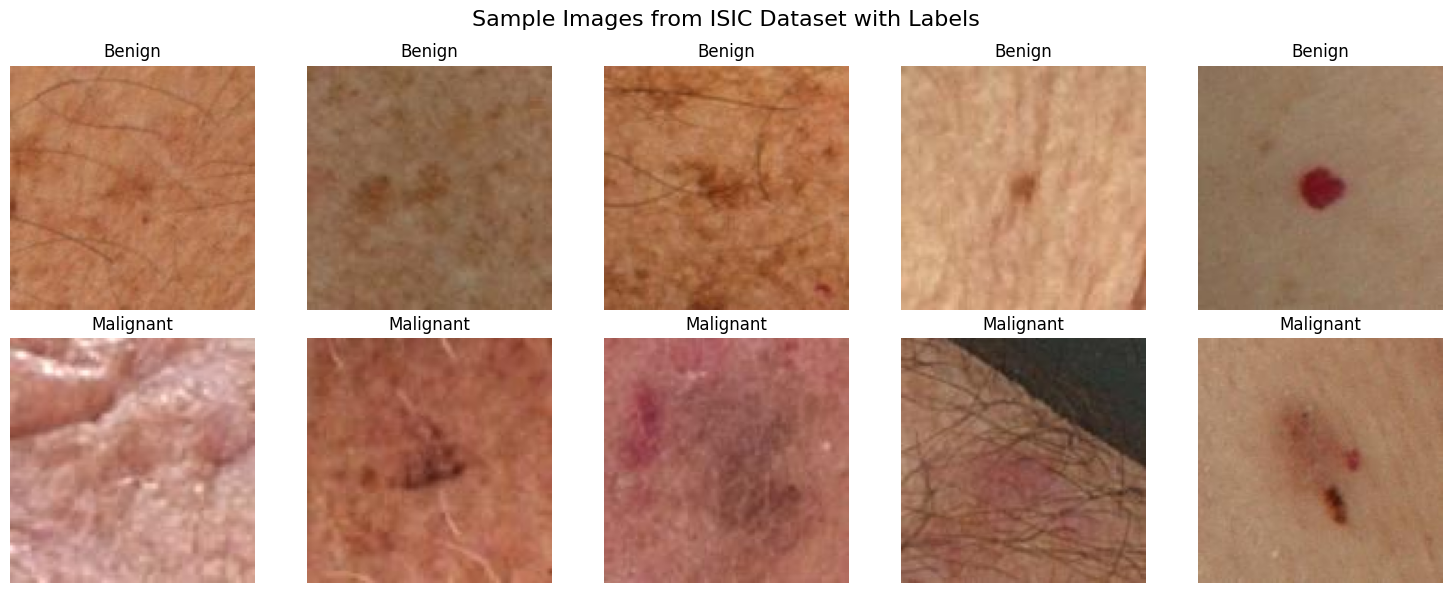

In [ ]:
image_dir = "/content/train-image/image"

benign_df = train_metadata[train_metadata['target'] == 0]
malignant_df = train_metadata[train_metadata['target'] == 1]

benign_sample = benign_df.sample(5, random_state=42)
malignant_sample = malignant_df.sample(5, random_state=42)
sample_df = pd.concat([benign_sample, malignant_sample])
plt.figure(figsize=(15, 6))
for i, (index, row) in enumerate(sample_df.iterrows()):
    isic_id = row['isic_id']
    label = "Malignant" if row['target'] == 1 else "Benign"
    image_path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{label}")
    plt.axis('off')

plt.suptitle("Sample Images from ISIC Dataset with Labels", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
columns_to_remove = ['lesion_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm']
train_metadata_cleaned = train_metadata.drop(columns=columns_to_remove, errors='ignore')
train_metadata_cleaned_no_nulls = train_metadata_cleaned.dropna()

In [ ]:
train_metadata_cleaned_no_nulls['target'].value_counts()

,count
target,
0,381533
1,381


In [ ]:
majority_class = train_metadata_cleaned_no_nulls[train_metadata_cleaned_no_nulls['target'] == 0]
minority_class = train_metadata_cleaned_no_nulls[train_metadata_cleaned_no_nulls['target'] == 1]

majority_class_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)
train_metadata_balanced = pd.concat([majority_class_downsampled, minority_class])
print("Class Distribution after balancing:\n", train_metadata_balanced['target'].value_counts())

Shape after balancing classes: (762, 48)
Class Distribution after balancing:
 target
0    381
1    381
Name: count, dtype: int64


In [ ]:
train_metadata_balanced.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,iddx_full,iddx_1,tbp_lv_dnn_lesion_confidence
44730,ISIC_1176500,0,IP_4013104,50.0,female,posterior torso,3.35,TBP tile: close-up,3D: white,21.195278,...,0.726667,60,-103.079308,1195.573975,227.486694,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.990058
362429,ISIC_9047349,0,IP_9057861,80.0,male,lower extremity,2.82,TBP tile: close-up,3D: white,17.323980,...,0.460432,110,-170.181000,764.250000,29.220830,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.999270
17389,ISIC_0500366,0,IP_6894380,45.0,female,posterior torso,4.81,TBP tile: close-up,3D: white,19.021500,...,0.207865,15,66.219480,1457.846000,78.279170,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.999990
367815,ISIC_9176171,0,IP_6422845,70.0,male,posterior torso,4.19,TBP tile: close-up,3D: white,19.501620,...,0.334615,55,-39.389570,1057.866000,169.172800,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.997030
192982,ISIC_4857877,0,IP_7331742,65.0,male,lower extremity,2.52,TBP tile: close-up,3D: XP,21.714430,...,0.185185,55,-150.631100,749.153000,-3.548462,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,Benign,Benign,99.999950


In [ ]:
X = train_metadata_balanced.drop(columns=['isic_id', 'target', 'patient_id', 'image_type', 'tbp_tile_type', 'attribution', 'copyright_license', 'iddx_full', 'iddx_1', 'tbp_lv_dnn_lesion_confidence'])
y = train_metadata_balanced['target']

In [ ]:
X_numeric = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)

In [ ]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [ ]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

input_dim = X_tensor.shape[1]
model = SimpleNN(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == y_batch).sum().item()
            total_predictions += y_batch.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct_predictions / total_predictions
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/20, Train Loss: 0.2972, Validation Loss: 0.4963, Validation Accuracy: 0.7712
Epoch 2/20, Train Loss: 0.3080, Validation Loss: 0.5034, Validation Accuracy: 0.7516
Epoch 3/20, Train Loss: 0.2864, Validation Loss: 0.4998, Validation Accuracy: 0.7778
Epoch 4/20, Train Loss: 0.2839, Validation Loss: 0.5093, Validation Accuracy: 0.7451
Epoch 5/20, Train Loss: 0.2734, Validation Loss: 0.5025, Validation Accuracy: 0.7647
Epoch 6/20, Train Loss: 0.2572, Validation Loss: 0.5016, Validation Accuracy: 0.7712
Epoch 7/20, Train Loss: 0.2436, Validation Loss: 0.5023, Validation Accuracy: 0.7582
Epoch 8/20, Train Loss: 0.2443, Validation Loss: 0.5090, Validation Accuracy: 0.7516
Epoch 9/20, Train Loss: 0.2391, Validation Loss: 0.5123, Validation Accuracy: 0.7582
Epoch 10/20, Train Loss: 0.2268, Validation Loss: 0.5065, Validation Accuracy: 0.7647
Epoch 11/20, Train Loss: 0.2214, Validation Loss: 0.5157, Validation Accuracy: 0.7647
Epoch 12/20, Train Loss: 0.2101, Validation Loss: 0.5174, Valid

In [ ]:
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        predictions = (outputs > 0.5).float()
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

Accuracy: 0.7712
Precision: 0.7973
Recall: 0.7468
F1 Score: 0.7712
ROC AUC Score: 0.7721


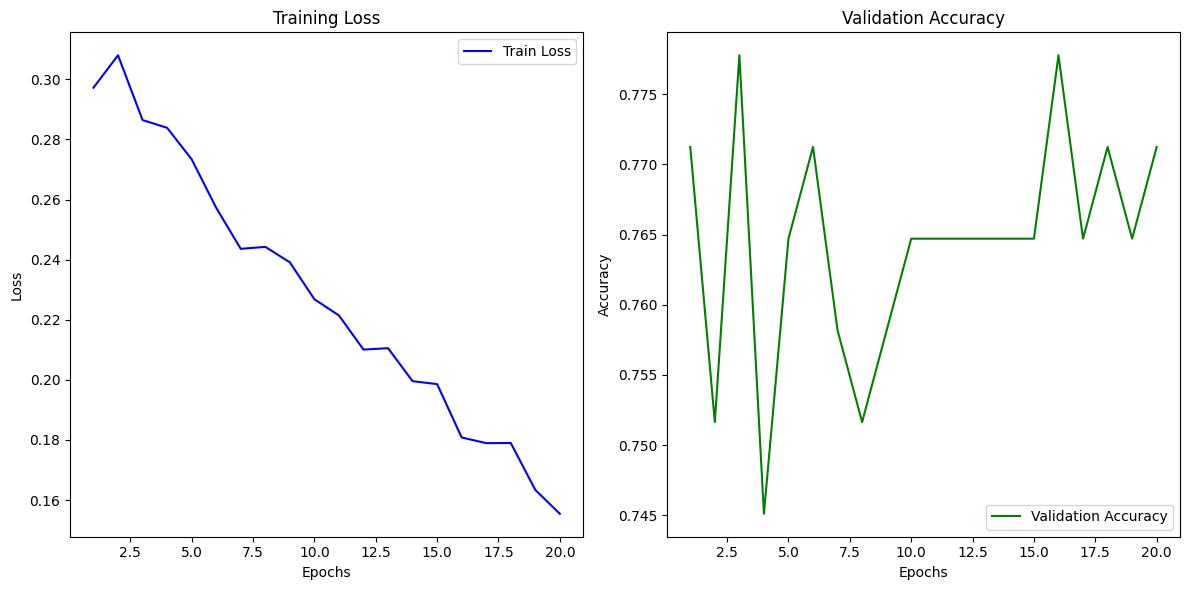

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Using device: cpu

Epoch 1/5 Results:
Training Loss: 0.9571
Validation Loss: 0.6981
Validation Accuracy: 0.6392
--------------------------------------------------

Epoch 2/5 Results:
Training Loss: 0.6188
Validation Loss: 0.5751
Validation Accuracy: 0.6835
--------------------------------------------------

Epoch 3/5 Results:
Training Loss: 0.5485
Validation Loss: 0.5165
Validation Accuracy: 0.7468
--------------------------------------------------

Epoch 4/5 Results:
Training Loss: 0.5376
Validation Loss: 0.5447
Validation Accuracy: 0.7025
--------------------------------------------------

Epoch 5/5 Results:
Training Loss: 0.5079
Validation Loss: 0.4540
Validation Accuracy: 0.7722
--------------------------------------------------
-------------------------
Accuracy: 0.7722
Precision: 0.7419
Recall: 0.8519
F1 Score: 0.7931
ROC AUC Score: 0.7701


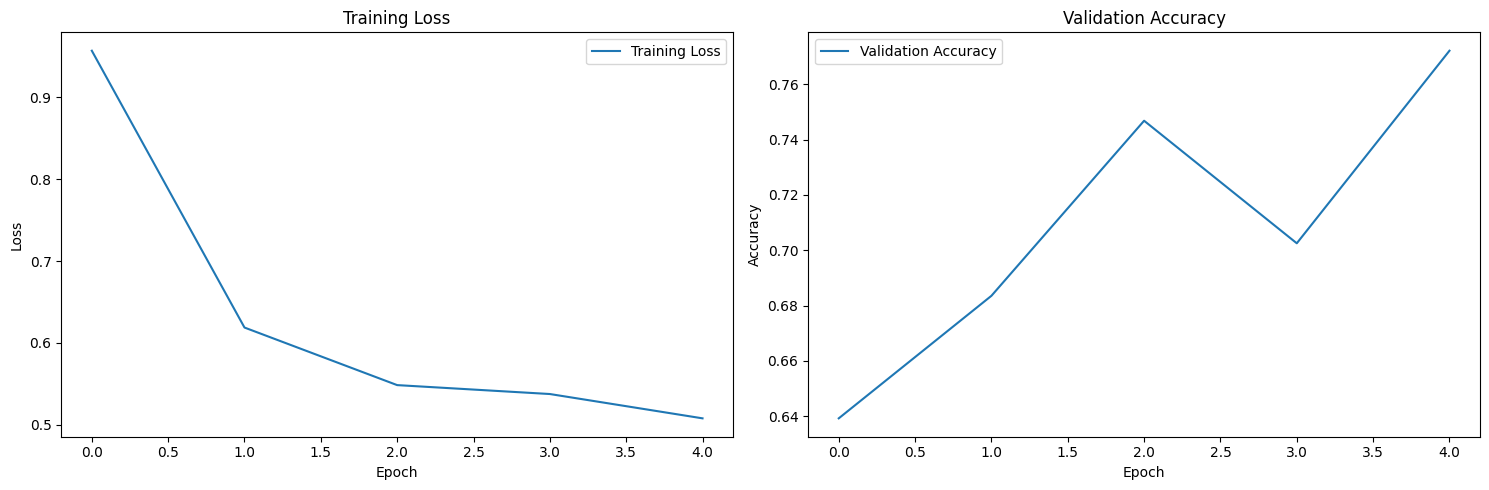

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

class ISICDataset(Dataset):
    def __init__(self, metadata, image_dir, transform=None):
        self.metadata = metadata
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        image_path = os.path.join(self.image_dir, f"{row['isic_id']}.jpg")
        image = Image.open(image_path).convert("RGB")
        label = row['target']

        if self.transform:
            image = self.transform(image)

        return image, label

class SimplifiedMelanomaNet(nn.Module):
    def __init__(self, num_classes=1):
        super(SimplifiedMelanomaNet, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

def main():
    train_metadata_path = "/content/train-metadata.csv"
    image_dir = "/content/train-image/image"

    metadata = pd.read_csv(train_metadata_path, low_memory=False)

    majority_class = metadata[metadata['target'] == 0]
    minority_class = metadata[metadata['target'] == 1]
    majority_class_downsampled = majority_class.sample(n=len(minority_class), random_state=42)
    balanced_metadata = pd.concat([majority_class_downsampled, minority_class])
    train_meta, val_meta = train_test_split(balanced_metadata, test_size=0.2, random_state=42)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = ISICDataset(train_meta, image_dir, transform=transform)
    val_dataset = ISICDataset(val_meta, image_dir, transform=transform)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    device = torch.device("cpu")
    print(f"Using device: {device}")

    model = SimplifiedMelanomaNet().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 5
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)

                outputs = model(images).squeeze(dim=1)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                predictions = (outputs > 0.5).float()
                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.size(0)

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct_predictions / total_predictions
        val_accuracies.append(val_accuracy)

        print(f"\nEpoch {epoch+1}/{num_epochs} Results:")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print("-" * 50)

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            predictions = (outputs > 0.5).float()

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predictions.cpu().squeeze().numpy())

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    print("-" * 25)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Save the model
    torch.save(model.state_dict(), 'simplified_melanoma_model.pth')

if __name__ == "__main__":
    main()

Epoch 1/10, Train Loss: 4.9330, Val Loss: 0.6458, Val Accuracy: 0.7089
Epoch 2/10, Train Loss: 0.5963, Val Loss: 0.5704, Val Accuracy: 0.7089
Epoch 3/10, Train Loss: 0.5546, Val Loss: 0.5098, Val Accuracy: 0.7215
Epoch 4/10, Train Loss: 0.4871, Val Loss: 0.4583, Val Accuracy: 0.8228
Epoch 5/10, Train Loss: 0.4806, Val Loss: 0.4702, Val Accuracy: 0.7658
Epoch 6/10, Train Loss: 0.4265, Val Loss: 0.4209, Val Accuracy: 0.8165
Epoch 7/10, Train Loss: 0.3739, Val Loss: 0.4206, Val Accuracy: 0.8038
Epoch 8/10, Train Loss: 0.3193, Val Loss: 0.4512, Val Accuracy: 0.7848
Epoch 9/10, Train Loss: 0.2520, Val Loss: 0.4114, Val Accuracy: 0.8038
Epoch 10/10, Train Loss: 0.1911, Val Loss: 0.4394, Val Accuracy: 0.8418


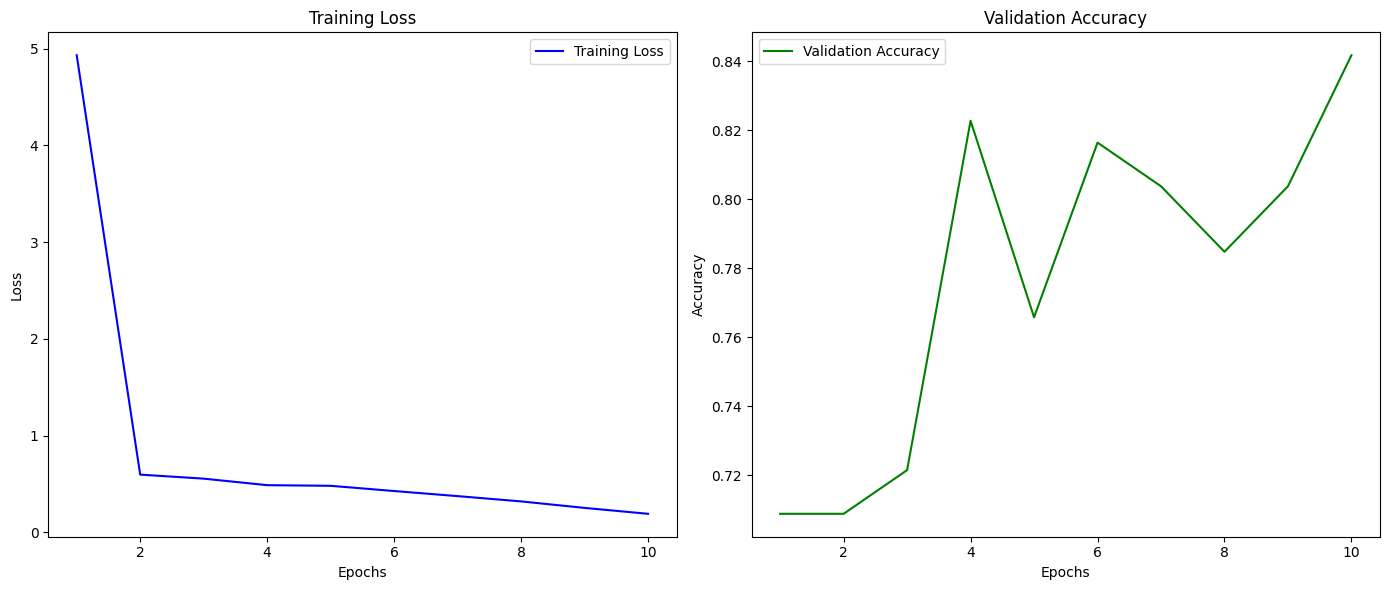

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class ISICDataset(Dataset):
    def __init__(self, metadata, image_dir, transform=None):
        self.metadata = metadata
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        image_path = os.path.join(self.image_dir, f"{row['isic_id']}.jpg")
        image = Image.open(image_path).convert("RGB")
        label = row['target']

        if self.transform:
            image = self.transform(image)

        return image, label

train_metadata_path = "/content/train-metadata.csv"
image_dir = "/content/train-image/image"

metadata = pd.read_csv(train_metadata_path,low_memory=False)

majority_class = metadata[metadata['target'] == 0]
minority_class = metadata[metadata['target'] == 1]
majority_class_downsampled = majority_class.sample(n=len(minority_class), random_state=42)
balanced_metadata = pd.concat([majority_class_downsampled, minority_class])

train_meta, val_meta = train_test_split(balanced_metadata, test_size=0.2, random_state=42)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = ISICDataset(train_meta, image_dir, transform=transform)
val_dataset = ISICDataset(val_meta, image_dir, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
device = torch.device("cpu")
model = CombinedCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze(dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        predictions = (outputs > 0.5).float()
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

Accuracy: 0.8418
Precision: 0.8684
Recall: 0.8148
F1 Score: 0.8408
ROC AUC Score: 0.8425


Confusion Matrix:
[[67 10]
 [15 66]]
Classification Report:
              precision    recall  f1-score   support

      Benign       0.82      0.87      0.84        77
   Malignant       0.87      0.81      0.84        81

    accuracy                           0.84       158
   macro avg       0.84      0.84      0.84       158
weighted avg       0.84      0.84      0.84       158



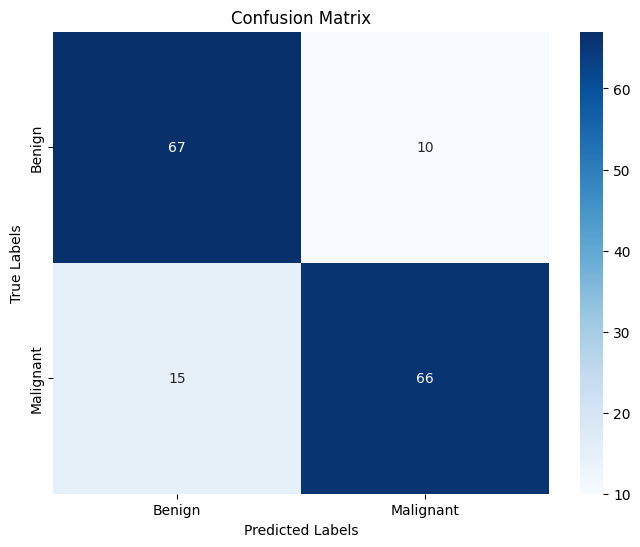

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model_with_predictions(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images).squeeze(dim=1)
            predictions = (outputs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())

    return all_labels, all_preds

all_labels, all_preds = evaluate_model_with_predictions(model, val_loader, device)

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

report = classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant'])
print("Classification Report:")
print(report)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
